# Análisis de datos R&D - LHCO 2020

En este notebook intentaremos entender la distribución y relaciones de los datos R&D del LHC Olympics 2020. Los datos se pueden descargar de [este link](https://zenodo.org/record/4536377).
El código está basado en [este notebook](https://github.com/lhcolympics2020/parsingscripts/blob/master/LHCOlympics2020_pyjetexample.ipynb).

In [1]:
# Importamos las librerías a utilizar
import h5py                             # Para manejar los archivos .h5
import numpy as np                      # Manejo de matrices
import matplotlib.pyplot as plt         # Plots
import pyjet as fj                      # Clustering de los jets
import pandas as pd                     # Manejo de tablas
import os.path                          # Manejo de directorios
from os import path

## Lectura de datos

In [ ]:
# leemos el archivo como un DataFrame de pandas
df = pd.read_hdf("../../events_anomalydetection.h5")

In [ ]:
# Vemos que sea del tipo esperado
type(df)

In [ ]:
# Vemos como luce el DataFrame
df.head()

El archivo tiene un evento por fila. Cada fila está compuesta por:
- al menos un jet anti-kT R = 1.0 
- con pseudorapidez $|\eta|<2,5$ 
- y momento transversal $pT> 1,2$ TeV. 

Para cada evento, hay una lista de todos los hadrones:

|Evento|$pT$ | $\eta$ | $\phi$ | $pT$ | $\eta$ | $\phi$ | $\cdots$ | Señal? |
|------|-----|--------|--------|------|--------|--------|--------|--------|
| 1    | $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 1.0|
| 2    | $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 0.0|
| $\vdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 0.0|


con relleno de ceros hasta 700 hadrones.


In [ ]:
# Sin embargo, tenemos muchos eventos
df.shape

Haremos la exploración de los datos en un conjunto más pequeño de eventos:

In [2]:
# Para el análisis, escogemos 1000 eventos de la muestra
n_eventos = 10000

In [ ]:
dfsample = df.sample(n=n_eventos)

In [ ]:
# Los guardamos en un archivo .h5 para tener la muestra en la que se haga el análisis
if path.exists("events_anomalydetection_tiny_{}.h5".format(n_eventos))!= True: 
    dfsample.to_hdf("events_anomalydetection_tiny_{}.h5".format(n_eventos), key='df', mode='w',complevel=5,complib='blosc')

In [3]:
# Utilizamos estos datos para el análisis
eventos_tiny = pd.read_hdf("events_anomalydetection_tiny_{}.h5".format(n_eventos))

In [4]:
# Tenemos un dataframe de 
# 1000 eventos x 700 hadrones * 3 características ( pT, eta, phi) + 1 columna (si es señal o fondo)

np.shape(eventos_tiny)

(10000, 2101)

La última columna tiene la información sobre si el evento es señal(1) o fondo(0)

In [5]:
eventos_tiny.iloc[:,-1].head()

76965     0.0
663565    0.0
764927    1.0
172549    0.0
155989    0.0
Name: 2100, dtype: float64

Podemos saber el porcentaje de señal y de fondo en la muestra:

In [ ]:
# Separamos el dataframe en señal y fondo
senal = eventos_tiny.loc[eventos_tiny.iloc[:,-1] == 1.0]
fondo = eventos_tiny.loc[eventos_tiny.iloc[:,-1] == 0.0]

# Obtenemos el numero de eventos (filas) del dataframe de señal, fondo y el de la muestra
n_senal = senal.shape[0]
n_fondo = fondo.shape[0]
n_eventos = eventos_tiny.shape[0]

# obtenemos la columna de señal de dataframe con todos los eventos
columna_senal = df.iloc[:,-1]

# separamos señal y fondo 
senaldf = columna_senal.loc[columna_senal == 1.0]
fondodf = columna_senal.loc[columna_senal == 0.0]

# Obtenemos el número de eventos (filas) del dataframe de señal, fondo y el de todos los eventos
ndf_senal = senaldf.shape[0]
ndf_fondo = fondodf.shape[0]
n_eventosdf = df.shape[0]

print('El {}% de los datos en la muestra de {} eventos es señal y el {}% es fondo'.format(n_senal/n_eventos*100,n_eventos,n_fondo/n_eventos*100 ))
print('El {}% de los datos R&D es señal y el {}% es fondo'.format(ndf_senal/n_eventosdf*100,ndf_fondo/n_eventosdf*100 ))

La ventaja de tener los datos en un dataframe es que podemos **utilizar la información fácilmente**.

Por ejemplo, para el clustering vamos a utilizar una lista que contenga los pT de cada jet si estos son mayores que 0.

In [6]:
# Por ejemplo, para el primer evento
lista= [data for data in eventos_tiny.iloc[0,::3] if data > 0] # pT, eta, phi, pT... Los pT están cada 3

# Vemos los primeros elementos
lista[0:5]

[0.3059094250202179,
 0.528335690498352,
 0.6266452670097351,
 0.40856659412384033,
 0.8071150183677673]

In [7]:
# el largo de cada lista varía según el evento. Esto representa la cantidad de hadrones por evento.
for evento in range(5):
    # Quitamos la fila de señal para no contarla como parte de los datos
    eventos_ss = eventos_tiny.iloc[:,:-1]  
    
    lista = [data for data in eventos_ss.iloc[evento,::3] if data > 0]
    print("Cantidad de hadrones en evento {}: {}".format(evento, len(lista)))

Cantidad de hadrones en evento 0: 145
Cantidad de hadrones en evento 1: 127
Cantidad de hadrones en evento 2: 80
Cantidad de hadrones en evento 3: 319
Cantidad de hadrones en evento 4: 144


Calculamos el **número promedio de hadrones** para los eventos de señal y de fondo:

In [8]:
def plot_dist(fondo, senal, xlabel, ylabel, titulo, n_bins=50):
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    if type(fondo)==list:
        plt.hist(fondo, bins=n_bins, facecolor='b', alpha=0.2,label='fondo', density=True)
        plt.hist(senal, bins=n_bins, facecolor='r', alpha=0.2,label='señal', density=True)
        
    else:
       # Hacemos los histogramas
        fondo.plot.hist(bins=n_bins, facecolor='b', alpha=0.2, label='fondo', density=True)
        senal.plot.hist(bins=n_bins, facecolor='r', alpha=0.2, label='señal', density=True)

    # Agregamos información al gráfico
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')
    plt.title(titulo)
    
    return plt.show()

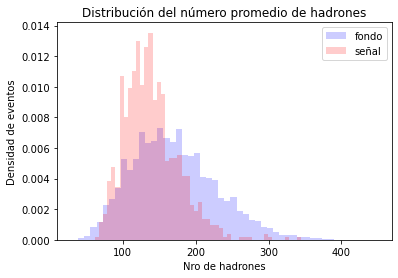

El número promedio de hadrones en los eventos de señal: 139 y en los eventos de fondo: 170


In [9]:
contar_h = eventos_tiny.copy()

# Quitamos la fila de señal para no contarla como parte de los datos
contar_h_ss = contar_h.iloc[:,:-1]
contar_h['Nro_hadrones'] = contar_h_ss.astype(bool).sum(axis=1)/3

h_senal = contar_h['Nro_hadrones'].loc[contar_h.iloc[:,-2] == 1.0]        # -2 porque al crear la columna Nro_hadrones,
h_fondo = contar_h['Nro_hadrones'].loc[contar_h.iloc[:,-2] == 0.0]        # la de señal ya no es la última

# Graficamos
plot_dist(h_fondo, h_senal, 
          r'Nro de hadrones', r'Densidad de eventos', 
          r'Distribución del número promedio de hadrones')

print('El número promedio de hadrones en los eventos de señal: {} y en los eventos de fondo: {}'.format(int(h_senal.mean()), int(h_fondo.mean())))

Podemos hacer dataframes de solamente pT, eta o phi

In [10]:
# pT está cada 3, partiendo de 0.
pt_df = eventos_tiny.iloc[:,::3]

pt_df.head()

,0,3,6,9,12,15,18,21,24,27,...,2073,2076,2079,2082,2085,2088,2091,2094,2097,2100
76965,0.305909,0.528336,0.626645,0.408567,0.807115,1.751847,5.753023,5.026085,2.599985,1.691981,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
663565,0.346507,2.144240,3.382292,7.478111,3.700897,1.723265,1.035048,2.286025,0.902282,1.148937,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
764927,0.294778,0.252465,0.468315,0.873560,2.932212,3.113694,2.920786,23.101059,25.980949,174.390106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
172549,0.427332,4.181561,4.167324,14.642617,2.055962,2.496214,3.772997,2.432942,1.444579,3.499435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155989,0.185630,0.456190,0.654748,1.376008,5.394917,1.839111,2.167102,3.372581,2.161964,1.225603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Hacemos lo mismo con eta y phi

# Definimos la columna con la información de señal o fondo
senal_column = eventos_tiny[2100]

# Concatenamos esta a los slicing de los dataframe
eta_df = pd.concat([eventos_tiny.iloc[:,1::3],senal_column], axis = 1)
phi_df = pd.concat([eventos_tiny.iloc[:,2::3],senal_column], axis = 1)

### Gráficas de la media

Antes del clustering, podemos graficar la distribución de los datos para cada evento.

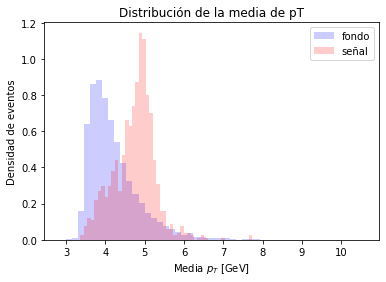

In [12]:
# Distribución de la media de pT para cada evento

# Filtramos que elementos son señal o fondo
pt_senal = pt_df.loc[pt_df.iloc[:,-1] == 1.0]
pt_fondo = pt_df.loc[pt_df.iloc[:,-1] == 0.0]

# Eliminamos la ultima columna de ambos
pt_senal = pt_senal.iloc[:,:-1]
pt_fondo = pt_fondo.iloc[:,:-1]

# Calculamos la media de las filas
meanpt_fondo = pt_fondo.mean(axis=1)
meanpt_senal = pt_senal.mean(axis=1)

# Graficamos
plot_dist(meanpt_fondo, meanpt_senal, 
          r'Media $p_{T}$ [GeV]', r'Densidad de eventos', 
          r'Distribución de la media de pT')

Podemos hacer lo mismo para $\eta$ y $\phi$:

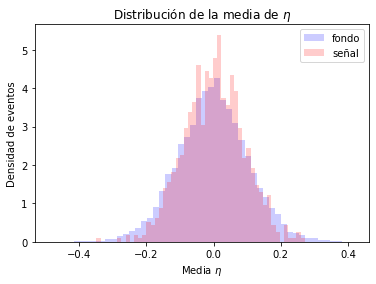

In [13]:
# Distribución de la media de eta para cada evento

# Filtramos que elementos son señal o fondo
eta_senal = eta_df.loc[eta_df.iloc[:,-1] == 1.0]
eta_fondo = eta_df.loc[eta_df.iloc[:,-1] == 0.0]

# Eliminamos la ultima columna de ambos
eta_senal = eta_senal.iloc[:,:-1]
eta_fondo = eta_fondo.iloc[:,:-1]

# Calculamos la media de las filas y hacemos un histograma
meaneta_fondo = eta_fondo.mean(axis=1)
meaneta_senal = eta_senal.mean(axis=1)

# Graficamos
plot_dist(meaneta_fondo, meaneta_senal, 
          r'Media $\eta$', r'Densidad de eventos', 
          r'Distribución de la media de $\eta$')

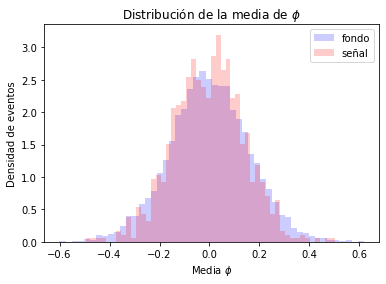

In [14]:
# Distribución de la media de phi para cada evento

# Filtramos que elementos son señal o fondo
phi_senal = phi_df.loc[phi_df.iloc[:,-1] == 1.0]
phi_fondo = phi_df.loc[phi_df.iloc[:,-1] == 0.0]

# Eliminamos la ultima columna de ambos
phi_senal = phi_senal.iloc[:,:-1]
phi_fondo = phi_fondo.iloc[:,:-1]


# Calculamos la media de las filas y hacemos un histograma
meanphi_fondo = phi_fondo.mean(axis=1)
meanphi_senal = phi_senal.mean(axis=1)

plot_dist(meanphi_fondo, meanphi_senal, 
          r'Media $\phi$', r'Densidad de eventos', 
          r'Distribución de la media de $\phi$')

### Gráficas del hadrón más energético

Analizamos el hadron más energético. Para esto hallaremos el mayor pT en cada evento

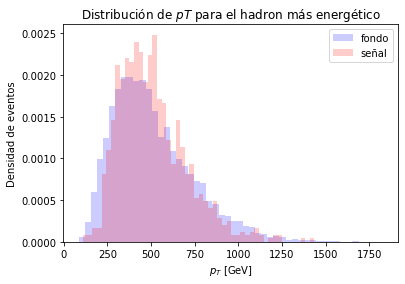

In [15]:
# Distribución de la pT para hadron mas energetico en cada evento

# Hallamos el maximo en cada fila para señal y fondo
ptmax_senal = pt_senal.max(axis=1)
ptmax_fondo = pt_fondo.max(axis=1)

# Hallamos los nombres de las columnas. Lo usaremos para obtener eta y phi de este hadron
col_ptmax_s = pt_senal.idxmax(axis=1)
col_ptmax_f = pt_fondo.idxmax(axis=1)

# Graficamos
plot_dist(ptmax_fondo, ptmax_senal, 
          r'$p_{T}$ [GeV]', r'Densidad de eventos', 
          r'Distribución de $pT$ para el hadron más energético')

<ipython-input-16-df261b44b202>:8: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  etamax_senal = pd.Series(eta_senal.lookup(col_etamax_s.index, col_etamax_s.values))
<ipython-input-16-df261b44b202>:9: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  etamax_fondo = pd.Series(eta_fondo.lookup(col_etamax_f.index, col_etamax_f.values))


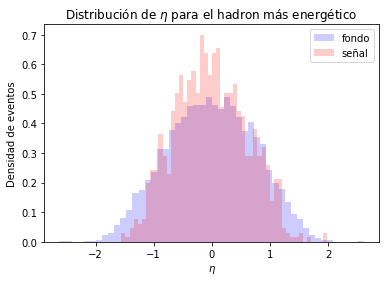

In [16]:
# Hallamos la columna con eta del hadron mas energetico. Es la siguiente a la de pT mas energetico.
col_etamax_s = col_ptmax_s + 1 
col_etamax_f = col_ptmax_f + 1

# Hacemos el mapeo de las columnas para extraerlas del dataframe
# https://stackoverflow.com/questions/50341927/select-pandas-column-for-each-row-by-index-list

etamax_senal = pd.Series(eta_senal.lookup(col_etamax_s.index, col_etamax_s.values))
etamax_fondo = pd.Series(eta_fondo.lookup(col_etamax_f.index, col_etamax_f.values))

# Graficamos

plot_dist(etamax_fondo, etamax_senal, 
          r'$\eta$', r'Densidad de eventos', 
          r'Distribución de $\eta$ para el hadron más energético')

<ipython-input-17-c248a6e5ab69>:6: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  phimax_senal = pd.Series(phi_senal.lookup(col_phimax_s.index, col_phimax_s.values))
<ipython-input-17-c248a6e5ab69>:7: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  phimax_fondo = pd.Series(phi_fondo.lookup(col_phimax_f.index, col_phimax_f.values))


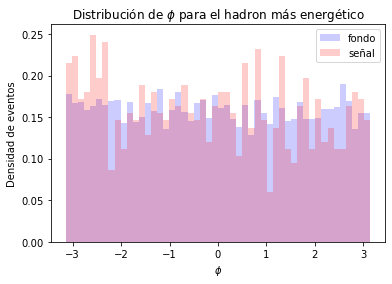

In [17]:
# Hallamos la columna con eta del hadron mas energetico. Es la segunda siguiente a la de pT mas energetico.
col_phimax_s = col_ptmax_s + 2 
col_phimax_f = col_ptmax_f + 2

# Hacemos el mapeo de las columnas para extraerlas del dataframe
phimax_senal = pd.Series(phi_senal.lookup(col_phimax_s.index, col_phimax_s.values))
phimax_fondo = pd.Series(phi_fondo.lookup(col_phimax_f.index, col_phimax_f.values))

# Graficamos
plot_dist(phimax_fondo, phimax_senal, 
          r'$\phi$', r'Densidad de eventos', 
          r'Distribución de $\phi$ para el hadron más energético')

## Clustering

Para el clustering vamos a usar la librería <code>pyjet</code>. Esta librería permite hacer el clustering de los jets mediante FastJet y arreglos de NumPy. 

**FastJet** posee 3 clases principales que formarán parte del clustering:
- *PseudoJets*: provee un jet con cuadri-momento y algunos indices internos para situarlo en el contexto de una secuencia de clustering de jets.
- *JetDefinition*: contiene especificaciones sobre cómo se hará el clustering
- *ClusterSequence*: la clase que lleva a cabo el clustering y provee acceso a los jets finales.

Como input tenemos los 1000 eventos con hasta 700 hadrones y como output tendremos:
- Un diccionario con los jets de fondo y de señal en objetos PseudoJets
- Tres diccionario separado en señal y fondo con:
   - $pT$ del jet principal de cada evento
   - $\eta$ del jet principal de cada evento
   - $\phi$ del jet principal de cada evento


Primero definimos la función para hacer el clustering:

In [18]:
def jets_clustering(evento, R = 1.0, p = -1, ptmin=20): 

    """Genera una lista de jets dado un evento.

    Si el argumento `n_hadrones`, `R`, `p` y `ptmin` no es pasado, 
    se utilizan valores predeterminados.

    Parametros
    ----------
    evento : serie
        Hadrones del evento

    R : int
        Tamaño del radio a utilizar para el clustering (por defecto es 1)

    p : int
        Algoritmo a utilizar para el clustering (por defecto es -1 o kt)
    
    ptmin : int
        pT mínimo de los jets a listar (por defecto es 20)

    Devuelve
    ------
    lista
        Lista de objetos PseudoJets, o jets con ptmin clusterizados para el evento
    """
    
    datos_ss = evento.iloc[:-1]
    n_hadrones = int(evento.shape[0]/3)

    pseudojets_input = np.zeros(len([data for data in datos_ss.iloc[::3] if data > 0]), dtype= fj.DTYPE_PTEPM) 

    for hadron in range(n_hadrones):
        if (datos_ss.iloc[hadron*3] > 0): ## si pT > 0 

            ## Llenamos el arreglo con pT, eta y phi de cada "partícula"
            pseudojets_input[hadron]['pT'] = datos_ss.iloc[hadron*3] 
            pseudojets_input[hadron]['eta'] = datos_ss.iloc[hadron*3+1]
            pseudojets_input[hadron]['phi'] = datos_ss.iloc[hadron*3+2]

            pass
        pass

    ## Devuelve una "ClusterSequence" (un tipo de lista de pyjet)
    secuencia = fj.cluster(pseudojets_input, R = 1.0, p = -1) 

    ## Con inclusive_jets accedemos a todos los jets que fueron clusterizados
    ## y filtramos los que tienen pT mayor que 20.
    ## Hacemos una lista con objetos PseudoJet
    jets = secuencia.inclusive_jets(ptmin)
    
    return jets

Y algunas funciones para calcular variables:

In [19]:
def deltaR(x, y):
    return ((x.phi-y.phi)**2 + (x.eta-y.eta)**2)**0.5

def subjettiness(cndts, cnsts):
    d0 = sum(c.pt for c in cnsts)
    ls = []
    for c in cnsts:
        dRs = [deltaR(c,cd) for cd in cndts]
        ls += [c.pt * min(dRs)]
    return sum(ls)/d0

def tau21(jet,subR=0.2):
    '''Input: jet from the jet clustering result '''
    jet_substruct_features = {}        
    seq = fj.cluster(jet, R=subR, algo='kt')
    cnsts = jet.constituents()
    cndts1 = seq.exclusive_jets(1)
    tau1 = subjettiness(cndts1, cnsts)
    if (len(cnsts)>1):
        cndts2 = seq.exclusive_jets(2)
        tau2 = subjettiness(cndts2, cnsts)
    else: 
        tau2 = 0
    
    try:
        return tau2/tau1
    
    except ZeroDivisionError:
        return 0

Ahora, utilizamos esto para hacer el clustering de los eventos de señal y fondo por separado:

In [20]:
# Creamos las variables a utilizar
alljets={}                                     # diccionario con los jets de cada evento y su información
leadpT={}                                      # diccionario de pT del jet principal de cada evento
leadeta={}                                     # diccionario de eta del jet principal de cada evento
leadphi={}                                     # diccionario de phi del jet principal de cada evento
leadhadron={}                                  # diccionario del nro. de hadrones del jet principal de cada evento
leadsubjet={}                                  # diccionario del subjetiness del jet principal de cada evento
deltar={}                                      # diccionario de la distancia angular de los dos jets principales de cada evento
n_eventos = eventos_tiny.shape[0]              # número de eventos (1000)
n_hadrones = int((eventos_tiny.shape[1]-1)/3)  # número de hadrones (700) 
                                               # [-1 para eliminar la columna señal, /3 por las 3 caracteristicas de cada hadron]

print('CLUSTERING DE JETS')
print("En estos datos hay {} eventos y {} hadrones p/evento".format(n_eventos, n_hadrones))

for mitipo in ['fondo','senal']:
    # Creamos el key para cada diccionario 
    alljets[mitipo]=[] 
    leadpT[mitipo]=[]
    leadeta[mitipo]=[]  
    leadphi[mitipo]=[]
    leadhadron[mitipo] = []
    leadsubjet[mitipo] = []
    deltar[mitipo] = []
    
    for evento in range(n_eventos):
        # Indicamos que el código está corriendo
        if (evento%1000==0):
            print(mitipo,evento)
            pass
        
        # La última columna tiene la información sobre si el evento es señal(1) o fondo(0)
        essenal = eventos_tiny.iloc[evento,-1]
        
        # Si estamos en fondo solo analizamos los eventos que son fondo y viceversa.
        if (mitipo=='fondo' and essenal):
            continue
        elif (mitipo=='senal' and essenal==0):
             continue            
        
        eventos_tiny.iloc[evento,:]
        
        jets = jets_clustering(eventos_tiny.iloc[evento,:]) 
        
        # Agrega el pT, eta y phi del jet principal
        # ** No sé cómo están en orden **
        leadpT[mitipo] += [jets[0].pt] 
        leadeta[mitipo] += [jets[0].eta] 
        leadphi[mitipo] += [jets[0].phi]
        leadhadron[mitipo] += [len(jets[0].constituents())]
        leadsubjet[mitipo] += [tau21(jets[0])]
        deltar[mitipo] += [deltaR(jets[0], jets[1])]
        
        # agregamos todos los jets a alljets
        alljets[mitipo] += [jets] 
        
        '''
        ###################################CHEQUEANDO LOS TIPOS DE VARIABLES#############################################
        
        if evento==0 or evento==2000: 
            print('BREVE ANALISIS DE LAS VARIABLES')
            print('**pseudojets_input**: tipo {}, largo {}'.format(type(pseudojets_input), len(pseudojets_input)))
            print('**secuencia**: tipo {}'.format(type(secuencia)))
            print('**jets**: tipo {}, largo {}, tipo de objetos que contiene {}'.format(type(jets), len(jets), type(jets[0])))
            print('**leadpT**: tipo {}, largo {}, tipo de objeto que contiene {}'.format(type(leadpT), len(leadpT), type(leadpT[mitipo][0])))
            print('**alljets**: tipo {}, largo {}, tipo de objeto que contiene {}'.format(type(alljets), len(alljets), type(alljets[mitipo][0])))
        '''   
        
        pass        

CLUSTERING DE JETS
En estos datos hay 10000 eventos y 700 hadrones p/evento
fondo 0
fondo 1000
fondo 2000
fondo 3000
fondo 4000
fondo 5000
fondo 6000
fondo 7000
fondo 8000
fondo 9000
senal 0
senal 1000
senal 2000
senal 3000
senal 4000
senal 5000
senal 6000
senal 7000
senal 8000
senal 9000


Analicemos los datos para los jets reconstruidos. Veamos la distribución de jets reconstruidos para señal y fondo:

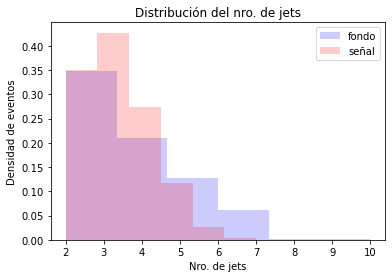

El número promedio de jets en los eventos de señal: 3 y en los eventos de fondo: 3


In [23]:
# Creamos un diccionario con la cantidad de jets reconstruidos por evento para señal y fondo
nro_jets = {}
for mitipo in alljets.keys():
    nro_jets[mitipo] = []
    nro_jets[mitipo] += [len(lista) for lista in alljets[mitipo]]

# Creamos series de los datos, para poder graficar fácilmente
nro_jets_fondo = pd.Series( (v for v in nro_jets['fondo']) )
nro_jets_senal = pd.Series( (v for v in nro_jets['senal']) )

# Graficamos
plot_dist(nro_jets_fondo, nro_jets_senal, 
          r'Nro. de jets', r'Densidad de eventos', 
          'Distribución del nro. de jets', n_bins=6)

print('El número promedio de jets en los eventos de señal: {} y en los eventos de fondo: {}'.format(int(nro_jets_senal.mean()), int(nro_jets_fondo.mean())))


### Gráficas

**Graficamos** la distribución de los valores de los jets principales:

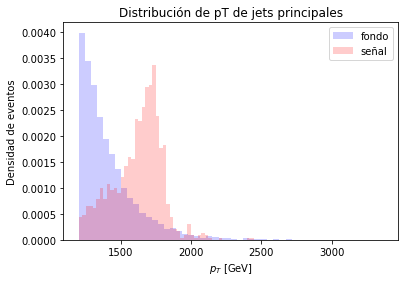

In [24]:
# Distribución de pT
plot_dist(leadpT['fondo'], leadpT['senal'], 
          r'$p_{T}$ [GeV]', 'Densidad de eventos', 
          'Distribución de pT de jets principales')

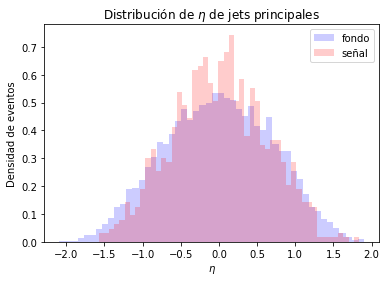

In [25]:
# Distribución de eta
plot_dist(leadeta['fondo'], leadeta['senal'], 
          r'$\eta$', 'Densidad de eventos', 
          'Distribución de $\eta$ de jets principales')

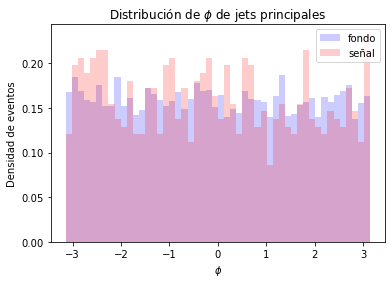

In [26]:
# Distribución de phi
plot_dist(leadphi['fondo'], leadphi['senal'], 
          r'$\phi$', 'Densidad de eventos', 
          'Distribución de $\phi$ de jets principales')

Utilizando funciones de FastJet sobre los objetos PseudoJets podemos calcular la masa invariante facilmente:

In [27]:
# MASA INVARIANTE
mjj={}

for mitipo in ['fondo','senal']:
    n_eventos = len(alljets[mitipo])
    mjj[mitipo]=[]
    
    for evento in range(n_eventos): 
        
        jet = alljets[mitipo][evento]
        
        # De cada evento sumamos la energía de los dos jets más energéticos
        E = jet[0].e + jet[1].e
        
        # Igual aqui pero con las componentes del momento
        px = jet[0].px + jet[1].px 
        py = jet[0].py + jet[1].py
        pz = jet[0].pz + jet[1].pz
        
        ## Calculamos la masa invariante
        mjj[mitipo]+=[(E**2-px**2-py**2-pz**2)**0.5] 
        pass
    pass

Y graficamos la distribución

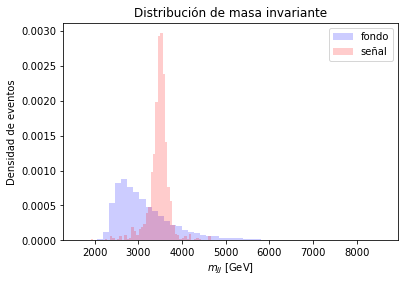

In [28]:
# Distribución de masa invariante
plot_dist(mjj['fondo'], mjj['senal'], 
          r'$m_{JJ}$ [GeV]', 'Densidad de eventos', 
          'Distribución de masa invariante')

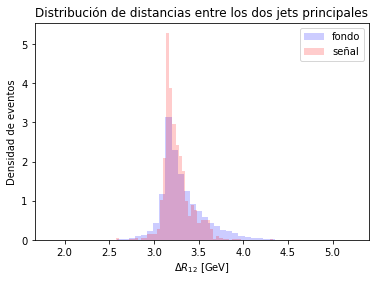

In [29]:
# Distribución de distancias
plot_dist(deltar['fondo'], deltar['senal'], 
          r'$\Delta R_{12}$ [GeV]', 'Densidad de eventos', 
          'Distribución de distancias entre los dos jets principales')

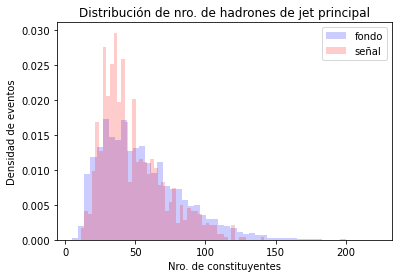

In [32]:
# Distribución de nro. de constituyentes
plot_dist(leadhadron['fondo'], leadhadron['senal'], 
          r'Nro. de constituyentes', 'Densidad de eventos', 
          'Distribución de nro. de hadrones de jet principal')

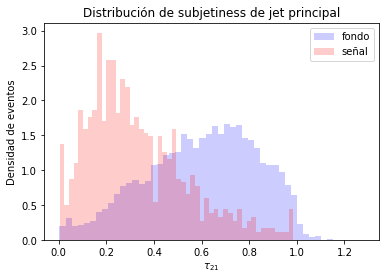

In [33]:
# Distribución de subjetiness
plot_dist(leadsubjet['fondo'], leadsubjet['senal'], 
          r'$\tau_{21}$', 'Densidad de eventos', 
          'Distribución de subjetiness de jet principal')

También podemos ver si hay alguna **relación entre las variables** graficando:

In [34]:
def plots_scatter(xfondo, yfondo, xsenal, ysenal, xlabel, ylabel, titulo):

    fig = plt.figure(figsize=[12, 4])

    # Creamos los subplots
    ax1 = fig.add_subplot(1,2, 1)
    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)

    # señal
    senal= ax2.scatter(xsenal, ysenal, c='r', alpha=0.5)
    ax2.label_outer()
    #ax2.set_title('Señal')

    # fondo
    fondo = ax1.scatter(xfondo, yfondo, c='b', alpha=0.5)
    ax1.set(ylabel=ylabel)
    #ax1.set_title('Fondo')

    # Colocamos el título y el eje x
    ax2.legend((senal, fondo), ('Señal', 'Fondo'), loc='upper right', prop={'size': 12})
    fig.suptitle(titulo)
    fig.text(0.5, 0.04, xlabel, ha='center', va='center')
    plt.subplots_adjust(wspace=0);
    
    return plt.show()

### Relación de la masa invariante con las demás variables

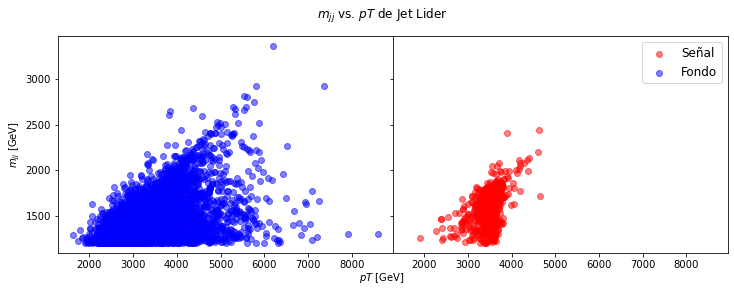

In [35]:
# Relación entre mjj y pT
plots_scatter(mjj['fondo'], leadpT['fondo'], 
              mjj['senal'], leadpT['senal'], 
              r'$pT$ [GeV]', r'$m_{jj}$ [GeV]', r'$m_{jj}$ vs. $pT$ de Jet Lider')

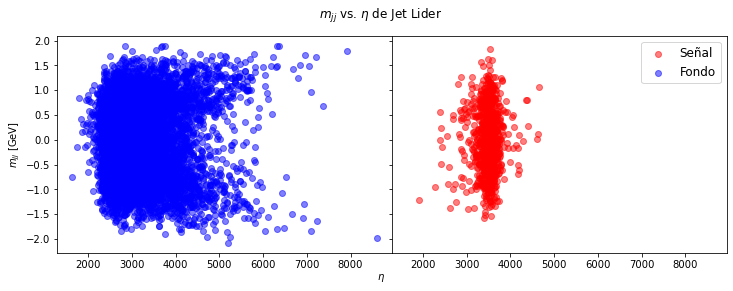

In [36]:
# Relación entre mjj y eta
plots_scatter(mjj['fondo'], leadeta['fondo'], 
              mjj['senal'], leadeta['senal'], 
              r'$\eta$', r'$m_{jj}$ [GeV]', r'$m_{jj}$ vs. $\eta$ de Jet Lider')

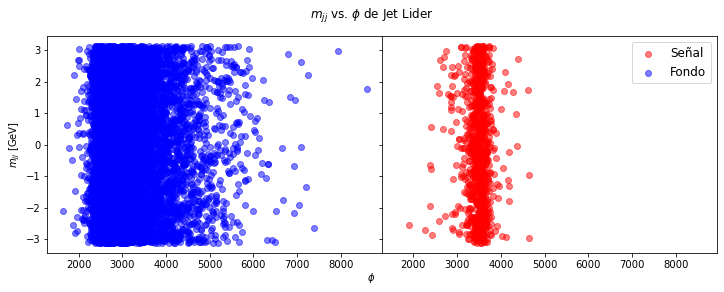

In [37]:
# Relación entre mjj y phi

plots_scatter(mjj['fondo'], leadphi['fondo'], 
              mjj['senal'], leadphi['senal'], 
              r'$\phi$', r'$m_{jj}$ [GeV]', r'$m_{jj}$ vs. $\phi$ de Jet Lider')

### Relación de pT con las demás variables 

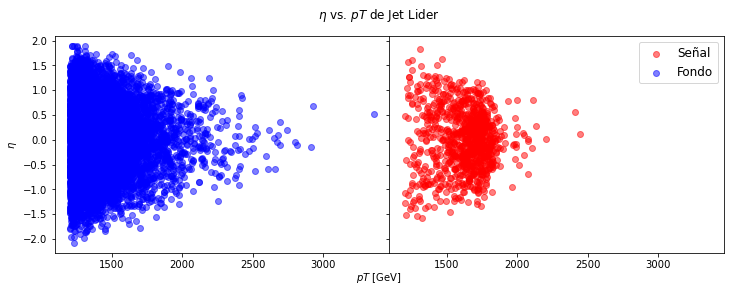

In [38]:
# Relación entre eta y pT

plots_scatter(leadpT['fondo'], leadeta['fondo'], 
              leadpT['senal'], leadeta['senal'], 
              r'$pT$ [GeV]', r'$\eta$', r'$\eta$ vs. $pT$ de Jet Lider')

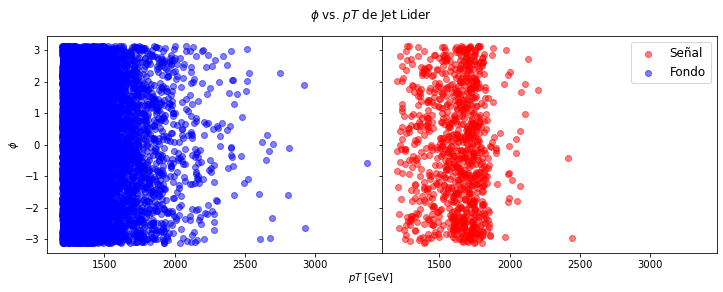

In [39]:
# Relación entre phi y pT

plots_scatter(leadpT['fondo'], leadphi['fondo'], 
              leadpT['senal'], leadphi['senal'], 
              r'$pT$ [GeV]', r'$\phi$', r'$\phi$ vs. $pT$ de Jet Lider')

### Relación de $\phi$ con las demás variables

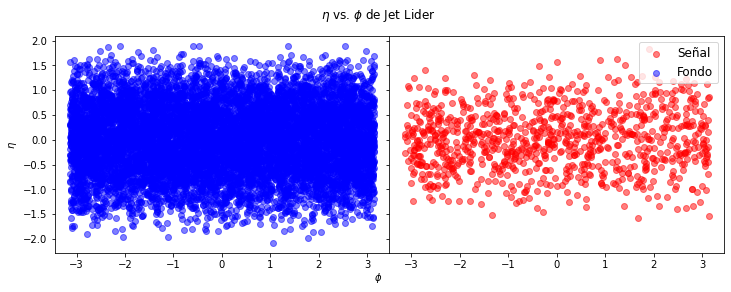

In [40]:
# Relación entre eta y phi

plots_scatter(leadphi['fondo'], leadeta['fondo'], 
              leadphi['senal'], leadeta['senal'], 
              r'$\phi$', r'$\eta$', r'$\eta$ vs. $\phi$ de Jet Lider')

### Relación de $m_{jj}$ con el número de hadrones

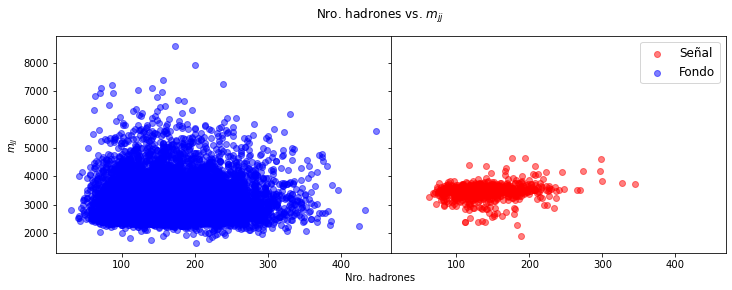

In [41]:
# Relación entre mjj y nro. hadrones

plots_scatter(h_fondo, mjj['fondo'], 
              h_senal, mjj['senal'], 
              r'Nro. hadrones', r'$m_{jj}$', r'Nro. hadrones vs. $m_{jj}$')